In [135]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
from utils import visualize, create_dataset_age, create_dataset, cv
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import warnings
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

In [124]:
warnings.filterwarnings('ignore')

## Create dataset

In [125]:
target = 'Age'
# use all MRI high-level features, no DTI
data = create_dataset(SCORE = target)
# for the moment, remove the diagnosis colums
try:
    data.drop(columns=['DX_01_Cat'], inplace=True)
except:
    pass
try:
    data.drop(columns=['DX_01_Sub'], inplace=True)
except:
    pass
try:
    data.drop(columns=['DX_01'], inplace=True)
except:
    pass

In [126]:
# Drop the rows with some NaNs
print(data.shape)
data.dropna(axis=0, inplace=True)
print(data.shape)
column_names = data.columns[2:]

(1146, 371)
(1146, 371)


In [127]:
# Scale the data
y = data[target]
X = data.drop([target, 'ID'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [128]:
# Baseline
mean = np.mean(y)
print('mean_age = {}'.format(mean))
baseline_MSE = sum((mean - y)**2)/len(y)
print('baseline_MSE = {}'.format(baseline_MSE))

mean_age = 10.719744772251309
baseline_MSE = 13.723839851203406


## Feature selection and regression


In [129]:
from sklearn.ensemble import ExtraTreesRegressor

Most relevant feature: lh_G_oc.temp_med.Lingual_thickness


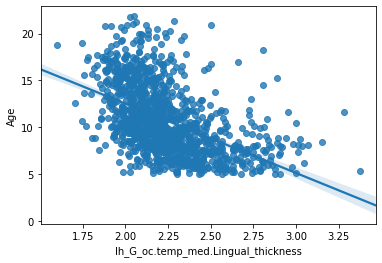

In [130]:
# Tree-based feature selection
tree = ExtraTreesRegressor(n_estimators=100, n_jobs=4)
tree = tree.fit(X=X_scaled, y=y)
weights = tree.feature_importances_

# Display correlation between most relevant feature and signal
most_relevant_feature = column_names[weights == max(weights)][0]
dataset = data[[target, most_relevant_feature]]
print('Most relevant feature: {}'.format(most_relevant_feature))
sns.regplot(x = most_relevant_feature, y = target ,data = dataset)

In [142]:
# Take the k most relevant features
k = 80
kth_weight = np.sort(weights)[::-1][k-1]
k_most_relevant = column_names[weights>= kth_weight]
print(k_most_relevant)
print(k_most_relevant.shape)

Index(['lh_G.S_frontomargin_thickness', 'lh_G.S_transv_frontopol_thickness',
       'lh_G.S_cingul.Ant_thickness', 'lh_G.S_cingul.Mid.Post_thickness',
       'lh_G_cingul.Post.dorsal_thickness', 'lh_G_cuneus_thickness',
       'lh_G_front_inf.Triangul_thickness', 'lh_G_Ins_lg.S_cent_ins_thickness',
       'lh_G_oc.temp_med.Lingual_thickness', 'lh_G_orbital_thickness',
       'lh_G_precentral_thickness', 'lh_G_precuneus_thickness',
       'lh_G_rectus_thickness', 'lh_G_subcallosal_thickness',
       'lh_G_temp_sup.Plan_polar_thickness', 'lh_S_calcarine_thickness',
       'lh_S_cingul.Marginalis_thickness', 'lh_S_front_middle_thickness',
       'lh_S_intrapariet.P_trans_thickness',
       'lh_S_oc_sup.transversal_thickness', 'lh_S_orbital.H_Shaped_thickness',
       'lh_S_parieto_occipital_thickness', 'lh_S_pericallosal_thickness',
       'lh_S_precentral.inf.part_thickness',
       'lh_S_precentral.sup.part_thickness', 'lh_S_suborbital_thickness',
       'lh_S_subparietal_thickness', 'B

In [132]:
X_selected = data[list(k_most_relevant)]
X_selected_scaled = scaler.fit_transform(X_selected)
X_selected.shape

(1146, 80)

In [133]:
# SVR
svm = SVR(kernel='rbf', C=1, epsilon=0.1)
svm_cv_res = cv(svm, data=X_selected_scaled, labels=y, n_splits=10)
print(svm_cv_res)
print('\nAverage MSE: {}'.format(np.mean(svm_cv_res)))

[3.5341417102645485, 4.577649245475539, 5.121557388388839, 4.517365516091129, 3.9010722502067967, 4.6958498506357245, 4.718764327749789, 4.598458726903144, 5.158442596530065, 4.9135613870265065]

Average MSE: 4.573686299927208


The decrease in MSE seems very promising, so we now repeat the procedure tidily with a pipeline (i.e. performing cross validation also on the feature selection stage).

## Pipeline

In [138]:
pipe = Pipeline([ ('scaling', StandardScaler()),
  ('feature_selection', SelectFromModel(estimator = ExtraTreesRegressor(n_estimators=100, n_jobs=4), threshold=-np.inf, max_features = k)),
  ('regression', SVR(kernel='rbf', C=1, epsilon=0.1))
])

In [141]:
pipe_cv_res = cv(pipe, data=X, labels=y, n_splits=10)
print(pipe_cv_res)
print('\nAverage MSE: {}'.format(np.mean(pipe_cv_res)))

[3.409860689119899, 4.826163531607888, 5.2869526991114855, 4.490093413175661, 3.9596244941705723, 4.884892743141886, 4.897268785693658, 4.676690045981558, 5.638375911967897, 4.989751415090188]

Average MSE: 4.705967372906069


The MSE estimate we just obtained should me more trustworthy since we also included the feature selection process in the pipeline --> in the cross validation procedure. (I hope pipeline works as I expect, maybe can you check carefully?)
Things to try now:
* try different regressors/feature selection methods
* perform parameter tuning by gridsearch
* next: when we are able to predict age with our best model, try to exploit discrepancy in real age and predictid cerebral age in disease prediction